In [17]:
import numpy as np
import random
import simpy
import matplotlib.pyplot as plt

### Ejercicio 4

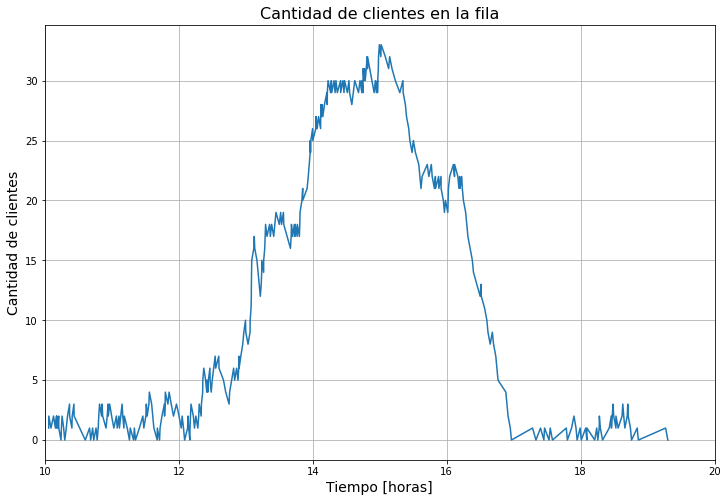

In [40]:
SEED = 10
random.seed(SEED)
np.random.seed(SEED)

def hours_to_min(hour):
    return hour * 60

def min_to_hours(minutes):
    return minutes / 60


class Client(object):
    simpy
    waiting_clients = 0
    data = []
    waiting_clients_data = []
    waiting_time_data = []

    def __init__(self, env):
        self.env = env
        self.type = np.random.choice(['1', '2', '3'], p=[0.1, 0.7, 0.2])
        self.service_time = {
            '1': random.randint(1,7),  # 4+-3 minutos => [1, 2, 3, 4, 5, 6, 7]
            '2': random.randint(1,3),  # 2+-1 minutos => [1, 2, 3]
            '3': random.randint(1,5)   # 3+-2 minutos => [1, 2, 3, 4, 5]
        }.get(self.type)
        self.arrival_time = 0

    def use_atm(self, atm):
        self.arrival_time = self.env.now
        Client.waiting_clients += 1
        Client.data.append((min_to_hours(self.env.now), Client.waiting_clients))
        Client.waiting_clients_data.append(Client.waiting_clients)
        
        # Automatic release
        with atm.request() as req:
            yield req
            yield self.env.timeout(self.get_service_time())
            
            Client.waiting_clients -= 1
            Client.data.append((min_to_hours(self.env.now), Client.waiting_clients))
            
            waiting_time = self.env.now - self.arrival_time
            Client.waiting_time_data.append(waiting_time)
            Client.waiting_clients_data.append(Client.waiting_clients)

            
    def get_service_time(self):
        return self.service_time


class Arrival(object):

    def __init__(self, env):
        self.env = env

    def generate(self):
        atm = simpy.Resource(env, capacity = 1)
        yield self.env.timeout(hours_to_min(10))

        while self.env.now <= hours_to_min(19):
            arrival_rate = self.get_arrival_rate(self.env.now)
            if arrival_rate == 0:
                yield self.env.timeout(hours_to_min(10) - self.env.now)
                continue
                
            t = random.expovariate(1 / arrival_rate)
            yield self.env.timeout(t)
            
            client = Client(self.env)
            self.env.process(client.use_atm(atm))
            
        self.end_clients()

        
    def end_clients(self):
        while  Client.waiting_clients > 0:
            yield self.env.timeout(0.1)
            client = Client(self.env)
            self.env.process(client.use_atm(atm))
            
            
    def get_arrival_rate(self, time):
        if time < hours_to_min(10):
            return 0
        if time < hours_to_min(12):
            return 4   # 240 segundos => 4 minutos
        elif time < hours_to_min(15):
            return 2   # 120 segundos => 2 minutos
        elif time <= hours_to_min(19):
            return 6   # 360 segundos => 6 minutos
        return 0
    

env = simpy.Environment()

arrivals = Arrival(env)
env.process(arrivals.generate())
env.run(until=hours_to_min(20))

plt.figure(figsize=(12,8))
plt.plot(*zip(*Client.data))
plt.title('Cantidad de clientes en la fila', fontsize=16)
plt.xlabel('Tiempo [horas]', fontsize=14)
plt.ylabel('Cantidad de clientes', fontsize=14)
plt.xlim(10, 20)
plt.grid()
plt.show()

In [39]:
print('Cantidad máxima de personas en fila esperando a usar el atm:', (max(Client.waiting_clients_data)))
print('Tiempo máximo de espera en fila: %.2f minutos.' % max(Client.waiting_time_data))

Cantidad máxima de personas en fila esperando a usar el atm: 33
Tiempo máximo de espera en fila: 80.91 minutos.
